# Solve Laplace equation for potential and velocity field using Deep Learing 

In this notebook we use a feedforward neural network (FFNN) to solve the Laplace equation using a boundary condition as input. 

**If using Google Colab, run this:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import time


# Preprocessing: Import data, show data etc.

Here we import the data. The data conists of linear standing waves. The training data, validation data and test data are all within one period of the wave. The training data consists of 100 time steps, the validation data of 250 time steps and the test data of 1000 time steps. \\
We note that the data consists of both the velocity potential, $P$, the horizontal velocity, $U$ and the vertical velocity, $W$. The naming convention will be used troughout the notebook. \\
We have also included unseen data. That is data, which with an arbitrary surface. This data set is used to test the generalation ability of the networks. 

In [4]:
Nx = 11
Ny = 11
Nsteps_train = 100
Nsteps_val = 250
Nsteps_test = 1000
Nsteps_uns = 100

data_train = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/DATA_Nx11Nz11Nt100_Train.csv', delimiter=',').reshape((Nsteps_train,3*Nx*Ny),order='A').astype('float32')
data_val = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/DATA_Nx11Nz11Nt250_Val.csv', delimiter=',').reshape((Nsteps_val,3*Nx*Ny),order='A').astype('float32')
data_test = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/DATA_Nx11Nz11Nt1000_Test.csv', delimiter=',').reshape((Nsteps_test,3*Nx*Ny),order='A').astype('float32')
data_unseen = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/DATA_ARB_Nx11Nz11Nt100_test.csv', delimiter=',').reshape((Nsteps_uns,3*Nx*Ny),order='A').astype('float32')
grid = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/Grid_Nx11Nz11Nt100_Train.csv', delimiter=',').reshape((Nx*Ny,3)).astype('float32')
x = grid[:,0]
X = x.reshape((Nx,Ny),order='F')
xx = X[0,:]
z = grid[:,1]
Z = z.reshape((Nx,Ny),order='F')
zz = Z[:,0]
s = grid[:,2]
S = s.reshape((Nx,Ny),order='F')
ss = S[:,0]

np.random.shuffle(data_train)

# Different domain indices
idx_2D = np.arange(0,3*Nx*Ny)
idx_surface = np.linspace(0,Nx*Ny,12).astype(int)
idx_surface = idx_surface[:-1]
idx_domain = np.setxor1d(idx_2D, idx_surface)
P_idx = range(0,Nx*Ny)
U_idx = range(Nx*Ny,2*Nx*Ny)
W_idx = range(2*Nx*Ny,3*Nx*Ny)

# Collect into inputs (X) and outputs (Y)
X_train = data_train[:,idx_surface]
Y_train = data_train
X_val = data_val[:,idx_surface]
Y_val = data_val
X_test = data_test[:,idx_surface]
Y_test = data_test
X_uns = data_unseen[:,idx_surface]
Y_uns = data_unseen


# Print data shapes
print('x-grid shape: ',xx.shape)
print('\nTraining data:')
print('Input shape : ',X_train.shape)
print('Output shape: ',Y_train.shape)
print('\nValidation data:')
print('Input shape : ',X_val.shape)
print('Output shape: ',Y_val.shape)
print('\nTest data:')
print('Input shape : ',X_test.shape)
print('Output shape: ',Y_test.shape)
print('\nUnseen data:')
print('Input shape : ',X_uns.shape)
print('Output shape: ',Y_uns.shape)

x-grid shape:  (11,)

Training data:
Input shape :  (100, 11)
Output shape:  (100, 363)

Validation data:
Input shape :  (250, 11)
Output shape:  (250, 363)

Test data:
Input shape :  (1000, 11)
Output shape:  (1000, 363)

Unseen data:
Input shape :  (100, 11)
Output shape:  (100, 363)


Below is an example of the input and the corresponding output. Notice that the input is equal to the output of the velocity potential, $P$ at $z=0$

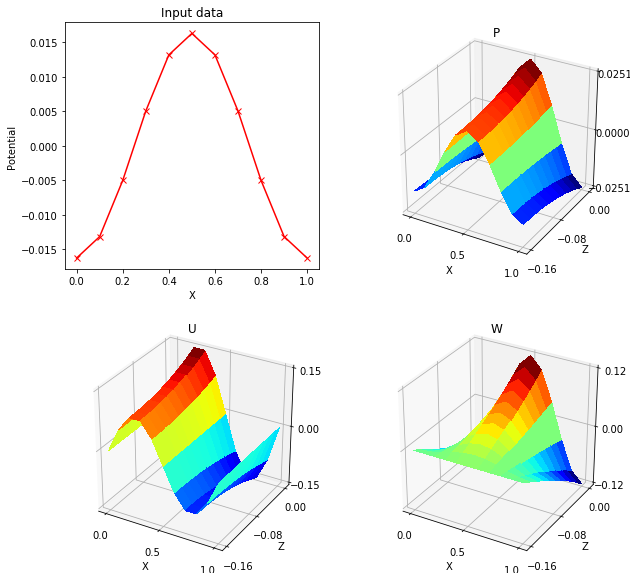

In [8]:
plot_idx=14
# Example of input (potential at surface)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
plt.plot(xx,X_train[plot_idx,:],'r-x')
ax.set_xlabel('X')
ax.set_ylabel('Potential')
ax.set_title('Input data')


# Example of corresponding output: Potential (entire domain)
#fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(2, 2, 2, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_train[plot_idx,P_idx]), 0, np.max(Y_train[plot_idx,P_idx])])
ax.set_title('P')
ax.plot_surface(X, Z, Y_train[plot_idx,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of corresponding horisontal velocity (entire domain)
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_train[plot_idx,U_idx]), 0, np.max(Y_train[plot_idx,U_idx])])
ax.set_title('U')
ax.plot_surface(X, Z, Y_train[plot_idx,U_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of corresponding vertical velocity (entire domain)
ax = fig.add_subplot(2, 2, 4, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_train[plot_idx,W_idx]), 0, np.max(Y_train[plot_idx,W_idx])])
ax.set_title('W')
ax.plot_surface(X, Z, Y_train[plot_idx,W_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

# Define Model

Next we will define our FFNN model. It consitst of 4 hidden layer with increasing size. We use the ReLU activation function at all hidden layers. For the output we have the linear activation function i.e. no activation. \\
Note that we will work with 2 networks. One with a smaller output (only the velocity potential) and one with a larger output (includin the velocity field as well). The two networks differ in their size of the hidden layers and the output layer. \\
Last we remark that no work on reducing overfitting has been done since the data are analytic solutions. 

In [0]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(Net, self).__init__()  
    # Weights
    self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(hidden_sizes[0], input_size)))
    self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(hidden_sizes[1], hidden_sizes[0])))
    self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(hidden_sizes[2], hidden_sizes[1])))
    self.W_4 = Parameter(init.kaiming_normal_(torch.Tensor(hidden_sizes[3], hidden_sizes[2])))
    self.W_5 = Parameter(init.kaiming_normal_(torch.Tensor(output_size, hidden_sizes[3])))

    self.b_1 = Parameter(init.constant_(torch.Tensor(hidden_sizes[0]), 0))
    self.b_2 = Parameter(init.constant_(torch.Tensor(hidden_sizes[1]), 0))
    self.b_3 = Parameter(init.constant_(torch.Tensor(hidden_sizes[2]), 0))
    self.b_4 = Parameter(init.constant_(torch.Tensor(hidden_sizes[3]), 0))
    self.b_5 = Parameter(init.constant_(torch.Tensor(output_size), 0))

    # Activation
    self.activation = nn.ReLU()

  def forward(self, x):
    x = F.linear(x, self.W_1, self.b_1)
    x = self.activation(x)

    x = F.linear(x, self.W_2, self.b_2)
    x = self.activation(x)

    x = F.linear(x, self.W_3, self.b_3)
    x = self.activation(x)

    x = F.linear(x, self.W_4, self.b_4)
    x = self.activation(x)

    x = F.linear(x, self.W_5, self.b_5)
    return x

In [21]:
# Test forward pass
units = [5*Nx, 10*Nx, 15*Nx, 25*Nx, 3*Nx*Ny] # Big network
units_P = [2*Nx, 4*Nx, 6*Nx, 8*Nx, Nx*Ny]    # Small network
Batch_size = 100

print('Small network:')
print('Size of hidden layers and output layer: ',units_P)
input_size = Nx
hidden_sizes = units_P[:-1]
output_size = units_P[-1]
FFNN_0 = Net(input_size, hidden_sizes,output_size)
input_test = np.random.normal(0, 1, (100, Nx)).astype('float32')
output_test = FFNN_0(Variable(torch.from_numpy(input_test)))
print('Expected output size:   [%i, %i]' %(Batch_size,output_size))
print('Output size from model: [%i, %i]' %(output_test.shape[0],output_test.shape[1]))

print('\nLarge network:')
print('Size of hidden layers and output layer: ',units)
input_size = Nx
hidden_sizes = units[:-1]
output_size = units[-1]
FFNN_1 = Net(input_size, hidden_sizes,output_size)
output_test = FFNN_1(Variable(torch.from_numpy(input_test)))
print('Expected output size:   [%i, %i]' %(Batch_size,output_size))
print('Output size from model: [%i, %i]' %(output_test.shape[0],output_test.shape[1]))

Small network:
Size of hidden layers and output layer:  [22, 44, 66, 88, 121]
Expected output size:   [100, 121]
Output size from model: [100, 121]

Large network:
Size of hidden layers and output layer:  [55, 110, 165, 275, 363]
Expected output size:   [100, 363]
Output size from model: [100, 363]


In [20]:
# Number of parameters for the networks
print('Number of parameters:')

pytorch_total_params = sum(p.numel() for p in FFNN_0.parameters() if p.requires_grad)
print('Small network:', pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in FFNN_1.parameters() if p.requires_grad)
print('Large network:', pytorch_total_params)

Number of parameters:
Small network: 20911
Large network: 170973


## Train Model

Here we train our networks. We use the simple mean-squared-error loss function. We train both networks for 2000 epochs.

In [0]:
def MSE_loss_func(output,target):
  MSE_loss = torch.mean((output-target)**2)
  return MSE_loss



First we train the small network

Epoch:   0, Train loss: 0.000275, Inf norm: 0.067092, Val loss: 0.000223, Val norm: 0.060473
Epoch: 200, Train loss: 0.000000, Inf norm: 0.002437, Val loss: 0.000000, Val norm: 0.002404
Epoch: 400, Train loss: 0.000000, Inf norm: 0.001189, Val loss: 0.000000, Val norm: 0.001306
Epoch: 600, Train loss: 0.000000, Inf norm: 0.000929, Val loss: 0.000000, Val norm: 0.001025
Epoch: 800, Train loss: 0.000000, Inf norm: 0.000714, Val loss: 0.000000, Val norm: 0.000922
Epoch: 1000, Train loss: 0.000000, Inf norm: 0.000685, Val loss: 0.000000, Val norm: 0.000842
Epoch: 1200, Train loss: 0.000000, Inf norm: 0.000589, Val loss: 0.000000, Val norm: 0.000769
Epoch: 1400, Train loss: 0.000000, Inf norm: 0.000583, Val loss: 0.000000, Val norm: 0.000757
Epoch: 1600, Train loss: 0.000000, Inf norm: 0.000563, Val loss: 0.000000, Val norm: 0.000713
Epoch: 1800, Train loss: 0.000000, Inf norm: 0.000540, Val loss: 0.000000, Val norm: 0.000726


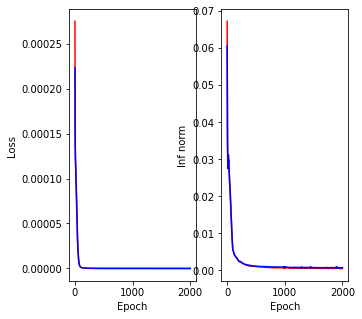

In [24]:
# Train Network
# Velocity potential network
input_size = Nx
hidden_sizes = units_P[:-1]
output_size = units_P[-1]
FFNN_P = Net(input_size, hidden_sizes,output_size)

# Select optimizer
optimizer = optim.Adam(FFNN_P.parameters(), lr=0.5e-3)
criterion = nn.MSELoss()

num_epochs = 2000

# setting up lists for handling loss/accuracy
train_norm, train_loss = [], []
val_norm, val_loss =  [], []
loss = 0
timing = []

for epoch in range(num_epochs):
  start = time.time()
  # Training for velocity potential
  FFNN_P.train()
  output = FFNN_P(Variable(torch.from_numpy(X_train)))
  target = Variable(torch.from_numpy(Y_train[:,P_idx].reshape((Nsteps_train,Nx*Ny))))
  loss = MSE_loss_func(output,target)
  train_norm.append(torch.max(torch.abs(output - target)))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  train_loss.append(loss)
  timing.append(time.time()-start)

  # Evaluation
  FFNN_P.eval()
  target_val = Variable(torch.from_numpy(Y_val[:,P_idx].reshape((Nsteps_val,Nx*Ny))))
  output_val = FFNN_P(Variable(torch.from_numpy(X_val)))
  val_loss.append(MSE_loss_func(output_val,target_val))
  val_norm.append(torch.max(torch.abs(output_val - target_val)))
  if epoch % (num_epochs/10) == 0:
    print('Epoch: %3i, Train loss: %f, Inf norm: %f, Val loss: %f, Val norm: %f' % (epoch,train_loss[-1], train_norm[-1],val_loss[-1], val_norm[-1]))

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss,'r-')
plt.plot(range(num_epochs),val_loss,'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_norm,'r-')
plt.plot(range(num_epochs),val_norm,'b-')
plt.xlabel('Epoch')
plt.ylabel('Inf norm')
plt.show()

# Save data into csv-files
#np.savetxt("/content/drive/My Drive/Results Deep Learning/train_loss_FFNN_P.csv", train_loss, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/val_loss_FFNN_P.csv", val_loss, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/train_norm_FFNN_P.csv", train_norm, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/val_norm_FFNN_P.csv", val_norm, delimiter=",")



We have computed the timings of the training:

In [25]:
avr_time = sum(timing)/num_epochs
print('Total time for training %i epochs : %.2f s' % (num_epochs, sum(timing)))
print('Average timing per epoch            : %.4f s' % avr_time)

Total time for training 2000 epochs : 5.02 s
Average timing per epoch            : 0.0025 s


Next we train the larger network

PUW: Epoch:   0, Train loss: 0.002285, Inf norm: 0.197160, Val loss: 0.002150, Val norm: 0.191140
PUW: Epoch: 200, Train loss: 0.000000, Inf norm: 0.003984, Val loss: 0.000000, Val norm: 0.003936
PUW: Epoch: 400, Train loss: 0.000000, Inf norm: 0.002053, Val loss: 0.000000, Val norm: 0.002198
PUW: Epoch: 600, Train loss: 0.000000, Inf norm: 0.001699, Val loss: 0.000000, Val norm: 0.001739
PUW: Epoch: 800, Train loss: 0.000000, Inf norm: 0.001466, Val loss: 0.000000, Val norm: 0.001611
PUW: Epoch: 1000, Train loss: 0.000000, Inf norm: 0.001327, Val loss: 0.000000, Val norm: 0.001801
PUW: Epoch: 1200, Train loss: 0.000000, Inf norm: 0.001113, Val loss: 0.000000, Val norm: 0.001155
PUW: Epoch: 1400, Train loss: 0.000000, Inf norm: 0.001020, Val loss: 0.000000, Val norm: 0.001162
PUW: Epoch: 1600, Train loss: 0.000000, Inf norm: 0.000965, Val loss: 0.000000, Val norm: 0.001247
PUW: Epoch: 1800, Train loss: 0.000000, Inf norm: 0.000882, Val loss: 0.000000, Val norm: 0.001019


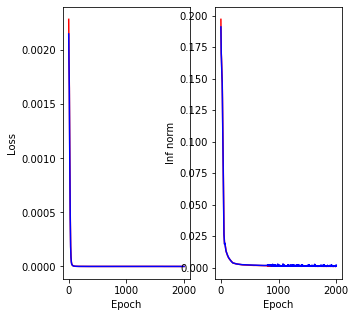

In [26]:
# Including velocity fields
input_size = Nx
hidden_sizes = units[:-1]
output_size = units[-1]
FFNN_PUW = Net(input_size, hidden_sizes,output_size)

# Select optimizer
optimizer = optim.Adam(FFNN_PUW.parameters(), lr=0.5e-3)
criterion = nn.MSELoss()

num_epochs = 2000

train_norm_PUW, train_loss_PUW = [], []
val_norm_PUW, val_loss_PUW = [], []
loss_PUW = 0
timing_PUW = []
for epoch in range(num_epochs):
  start = time.time()
  # Training for flow as well
  FFNN_PUW.train()
  output_PUW = FFNN_PUW(Variable(torch.from_numpy(X_train)))
  target_PUW = Variable(torch.from_numpy(Y_train.reshape((Nsteps_train,3*Nx*Ny))))
  loss_PUW = MSE_loss_func(output_PUW,target_PUW)
  train_norm_PUW.append(torch.max(torch.abs(output_PUW - target_PUW)))
  optimizer.zero_grad()
  loss_PUW.backward()
  optimizer.step()
  train_loss_PUW.append(loss_PUW)
  timing_PUW.append(time.time()-start)

  # Evaluation
  FFNN_PUW.eval()
  target_val = Variable(torch.from_numpy(Y_val.reshape((Nsteps_val,3*Nx*Ny))))
  output_val = FFNN_PUW(Variable(torch.from_numpy(X_val)))
  val_loss_PUW.append(MSE_loss_func(output_val,target_val))
  val_norm_PUW.append(torch.max(torch.abs(output_val - target_val)))
  if epoch % (num_epochs/10) == 0:
    print('PUW: Epoch: %3i, Train loss: %f, Inf norm: %f, Val loss: %f, Val norm: %f' % (epoch,train_loss_PUW[-1], train_norm_PUW[-1],val_loss_PUW[-1], val_norm_PUW[-1]))

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_PUW,'r-')
plt.plot(range(num_epochs),val_loss_PUW,'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_norm_PUW,'r-')
plt.plot(range(num_epochs),val_norm_PUW,'b-')
plt.xlabel('Epoch')
plt.ylabel('Inf norm')
plt.show()

# Save data into csv-files
#np.savetxt("/content/drive/My Drive/Results Deep Learning/train_loss_FFNN_PUW.csv", train_loss_PUW, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/val_loss_FFNN_PUW.csv", val_loss_PUW, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/train_norm_FFNN_PUW.csv", train_norm_PUW, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/val_norm_FFNN_PUW.csv", val_norm_PUW, delimiter=",")

In [27]:
avr_time = sum(timing_PUW)/num_epochs
print('Total time for training %i epochs : %.2f s' % (num_epochs, sum(timing_PUW)))
print('Average timing per epoch            : %.4f s' % avr_time)

Total time for training 2000 epochs : 13.81 s
Average timing per epoch            : 0.0069 s


## Test Model

Next we test both models on the test data. We run every test set through the models, time the forward pass and also evaluate the error (the infinity norm). \\
We have at the end plotted a box plot of all the test errors and also the test results with the largest error. 


Interval of inf norms: (0.000087, 0.000722)


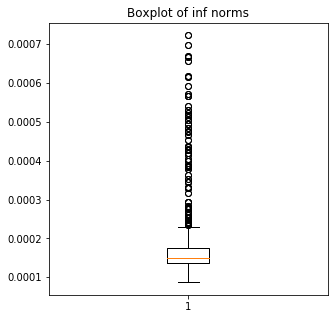




For the small network we observe the greatest error at test data #16


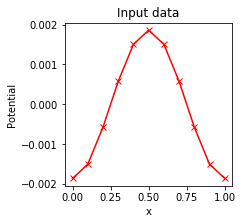

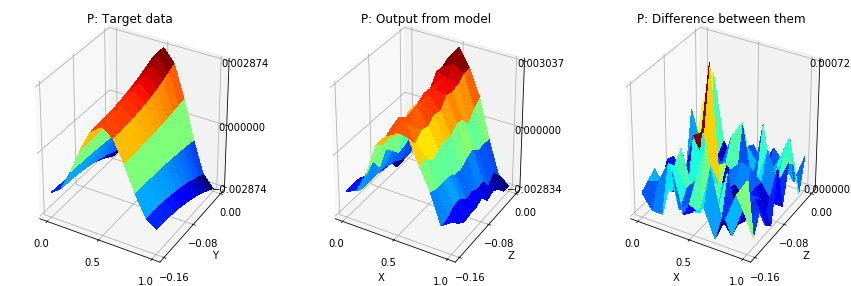




For the large network we observe the greatest error at test data #7 


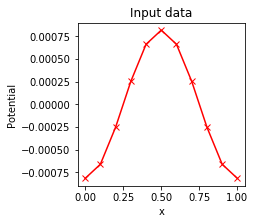

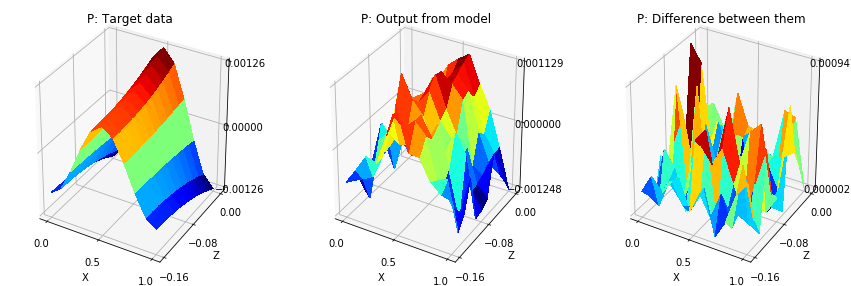

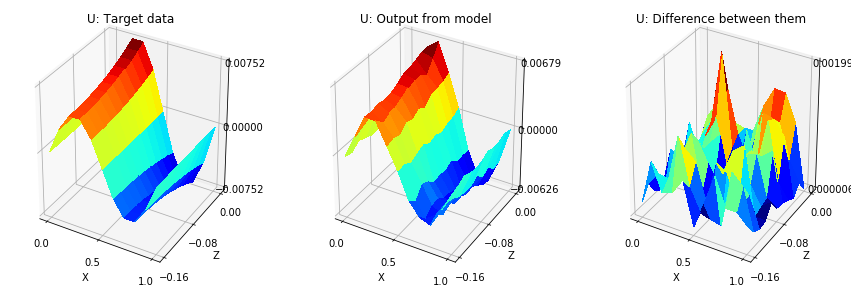

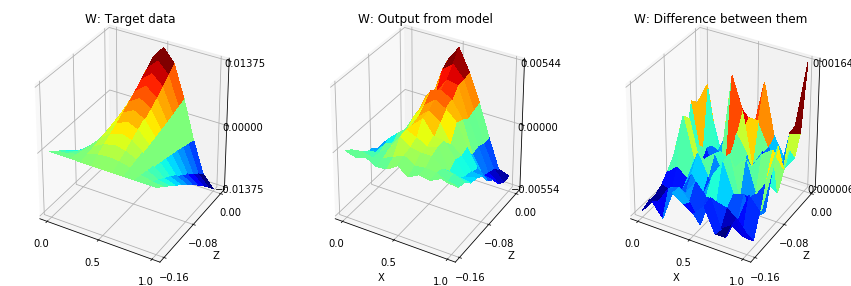

In [51]:
# Test network
test_loss, test_norm = [], []
test_loss_PUW, test_norm_PUW = [], []
outputs_from_test, error = [], []
outputs_from_test_PUW, error_PUW = [], []
timing_forward = []
timing_forward_PUW = []
FFNN_P.eval()
FFNN_PUW.eval()
for it in range(X_test.shape[0]):
  # Forward pass
  start = time.time()
  output_test = FFNN_P(Variable(torch.from_numpy(X_test[it,:].reshape((1,Nx)))))
  timing_forward.append(time.time()-start)
  start = time.time()
  output_test_PUW = FFNN_PUW(Variable(torch.from_numpy(X_test[it,:].reshape((1,Nx)))))
  timing_forward_PUW.append(time.time()-start)
  outputs_from_test.append(output_test.detach().numpy())
  outputs_from_test_PUW.append(output_test_PUW.detach().numpy())

  # Targets
  target_test = Variable(torch.from_numpy(Y_test[it,P_idx]).reshape((1,Nx*Ny)))
  target_test_PUW = Variable(torch.from_numpy(Y_test[it,:]).reshape((1,3*Nx*Ny)))

  # Loss
  loss_test = MSE_loss_func(output_test,target_test)
  loss_test_PUW = MSE_loss_func(output_test_PUW,target_test_PUW)
  test_loss.append(loss_test.detach().numpy())
  test_loss_PUW.append(loss_test_PUW.detach().numpy())
  error.append(torch.abs((output_test-target_test)).detach().numpy())
  error_PUW.append(torch.abs((output_test_PUW-target_test_PUW)).detach().numpy())

  # Norms
  norm_test = torch.max(torch.abs(output_test-target_test))
  norm_test_PUW = torch.max(torch.abs(output_test_PUW-target_test_PUW))
  test_norm.append(norm_test.detach().numpy())
  test_norm_PUW.append(norm_test_PUW.detach().numpy())

idx = np.argmax(test_norm)
idx_PUW = np.argmax(test_norm_PUW)

# Save into csv-files
#np.savetxt("/content/drive/My Drive/Results Deep Learning/X_test_PP_FFNNPUW.csv", X_test[idx,:], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_test_PP_FFNNPUW.csv", Y_test[idx,P_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_output_PP_FFNNPUW.csv", outputs_from_test[idx][0], delimiter=",")

#np.savetxt("/content/drive/My Drive/Results Deep Learning/X_test_FFNNPUW.csv", X_test[idx_PUW,:], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_test_P_FFNNPUW.csv", Y_test[idx_PUW,P_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_test_U_FFNNPUW.csv", Y_test[idx_PUW,U_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_test_W_FFNNPUW.csv", Y_test[idx_PUW,W_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_output_P_FFNNPUW.csv", outputs_from_test_PUW[idx_PUW][0][P_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_output_U_FFNNPUW.csv", outputs_from_test_PUW[idx_PUW][0][U_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_output_W_FFNNPUW.csv", outputs_from_test_PUW[idx_PUW][0][W_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Grid_FFNNPUW.csv", np.hstack((xx,zz)), delimiter=",")


print('\nInterval of inf norms: (%f, %f)' % (np.min(test_norm),np.max(test_norm)))
plt.figure(figsize=(5,5))
plt.boxplot(test_norm)
plt.title('Boxplot of inf norms')
plt.show()

print('\n\n\nFor the small network we observe the greatest error at test data #%i' % (idx))

# Example of a test input 
fig = plt.figure(figsize=(3,3))
plt.plot(xx,X_test[idx,:],'r-x')
plt.xlabel('x')
plt.ylabel('Potential')
plt.title('Input data')
plt.show()

############## Small network #################
# Example of corresponding target
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.set_ylabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_test[idx,P_idx]), 0, np.max(Y_test[idx,P_idx])])
ax.set_title('P: Target data')
ax.plot_surface(X, Z, Y_test[idx,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)
#plt.show()

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][P_idx]), 0, np.max(outputs_from_test[idx][0][P_idx])])
ax.set_title('P: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][P_idx]), 0, np.max(error[idx][0][P_idx])])
ax.set_title('P: Difference between them')
ax.plot_surface(X, Z, error[idx][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

print('\n\n\nFor the large network we observe the greatest error at test data #%i ' % (idx_PUW))

# Example of a test input 
fig = plt.figure(figsize=(3,3))
plt.plot(xx,X_test[idx_PUW,:],'r-x')
plt.xlabel('x')
plt.ylabel('Potential')
plt.title('Input data')
plt.show()

############## Large network #################
### PLOT P #####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_test[idx_PUW,P_idx]), 0, np.max(Y_test[idx_PUW,P_idx])])
ax.set_title('P: Target data')
ax.plot_surface(X, Z, Y_test[idx_PUW,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test_PUW[idx_PUW][0][P_idx]), 0, np.max(outputs_from_test_PUW[idx_PUW][0][P_idx])])
ax.set_title('P: Output from model')
ax.plot_surface(X, Z, outputs_from_test_PUW[idx_PUW][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error_PUW[idx_PUW][0][P_idx]), 0, np.max(error_PUW[idx_PUW][0][P_idx])])
ax.set_title('P: Difference between them')
ax.plot_surface(X, Z, error_PUW[idx_PUW][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

### PLOT U #####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_test[idx_PUW,U_idx]), 0, np.max(Y_test[idx_PUW,U_idx])])
ax.set_title('U: Target data')
ax.plot_surface(X, Z, Y_test[idx_PUW,U_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test_PUW[idx_PUW][0][U_idx]), 0, np.max(outputs_from_test_PUW[idx_PUW][0][U_idx])])
ax.set_title('U: Output from model')
ax.plot_surface(X, Z, outputs_from_test_PUW[idx_PUW][0][U_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error_PUW[idx_PUW][0][U_idx]), 0, np.max(error_PUW[idx_PUW][0][U_idx])])
ax.set_title('U: Difference between them')
ax.plot_surface(X, Z, error_PUW[idx_PUW][0][U_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

#### PLOT W ####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_test[idx,W_idx]), 0, np.max(Y_test[idx,W_idx])])
ax.set_title('W: Target data')
ax.plot_surface(X, Z, Y_test[idx,W_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test_PUW[idx_PUW][0][W_idx]), 0, np.max(outputs_from_test_PUW[idx_PUW][0][W_idx])])
ax.set_title('W: Output from model')
ax.plot_surface(X, Z, outputs_from_test_PUW[idx_PUW][0][W_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error_PUW[idx_PUW][0][W_idx]), 0, np.max(error_PUW[idx_PUW][0][W_idx])])
ax.set_title('W: Difference between them')
ax.plot_surface(X, Z, error_PUW[idx_PUW][0][W_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()


In [52]:
# Here we compute that largest errors
max_errors = []
max_errors_P = []
max_errors_U = []
max_errors_W = []
for it in range(Nsteps_test):
  max_errors.append(max(error[it][0]))
  max_errors_P.append(max(error_PUW[it][0][P_idx]))
  max_errors_U.append(max(error_PUW[it][0][U_idx]))
  max_errors_W.append(max(error_PUW[it][0][W_idx]))

print('Maximum errors:')
print('\nSmall network:')
print(max(max_errors))
print('\nLarge network:')
print('P',max(max_errors_P))
print('U',max(max_errors_U))
print('W',max(max_errors_W))

Maximum errors:

Small network:
0.00072237157

Large network:
P 0.0009478587
U 0.0019938163
W 0.001645722


In [53]:
print('Timing for forward pass: %e ' % (sum(timing_forward)/len(timing_forward)))
print('Timing for forward pass: %e ' % (sum(timing_forward_PUW)/len(timing_forward_PUW)))

Timing for forward pass: 2.638009e-04 
Timing for forward pass: 1.915853e-04 


# Test against unseen data

Here we test out model's ability to solve an arbitrary solution. That is we have a numerical solution to an arbitrary wave. An example of the wave is plotted here. 

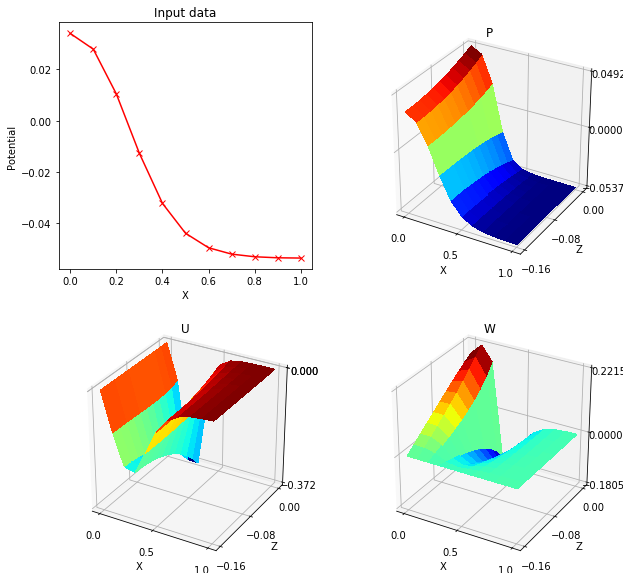

In [69]:
# Plot of unseen data
plot_idx = 10
# Example of input (potential at surface)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
plt.plot(xx,X_uns[plot_idx,:],'r-x')
ax.set_xlabel('X')
ax.set_ylabel('Potential')
ax.set_title('Input data')


# Example of corresponding output: Potential (entire domain)
ax = fig.add_subplot(2, 2, 2, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[plot_idx,P_idx]), 0, np.max(Y_uns[plot_idx,P_idx])])
ax.set_title('P')
ax.plot_surface(X, Z, Y_uns[plot_idx,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of corresponding horisontal velocity (entire domain)
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[plot_idx,U_idx]), 0, np.max(Y_uns[plot_idx,U_idx])])
ax.set_title('U')
ax.plot_surface(X, Z, Y_uns[plot_idx,U_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of corresponding vertical velocity (entire domain)
ax = fig.add_subplot(2, 2, 4, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[plot_idx,W_idx]), 0, np.max(Y_uns[plot_idx,W_idx])])
ax.set_title('W')
ax.plot_surface(X, Z, Y_uns[plot_idx,W_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

# Save to csv-file
#np.savetxt("/content/drive/My Drive/Results Deep Learning/X_uns_Ex_FFNNPUW.csv", X_uns[plot_idx,:], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_P_Ex_FFNNPUW.csv", Y_uns[plot_idx,P_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_U_Ex_FFNNPUW.csv", Y_uns[plot_idx,U_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_W_Ex_FFNNPUW.csv", Y_uns[plot_idx,W_idx], delimiter=",")



Here we run the test on the unseen data.

Interval of inf norms: (0.036504, 0.756457)


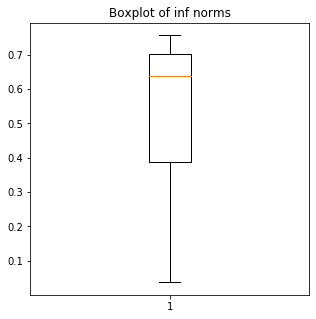

For test data #99 we observe the greatest error


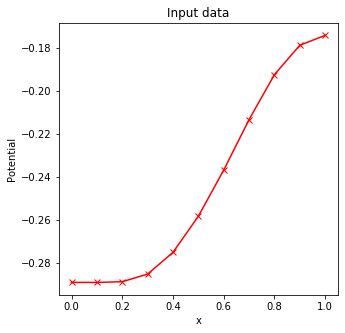

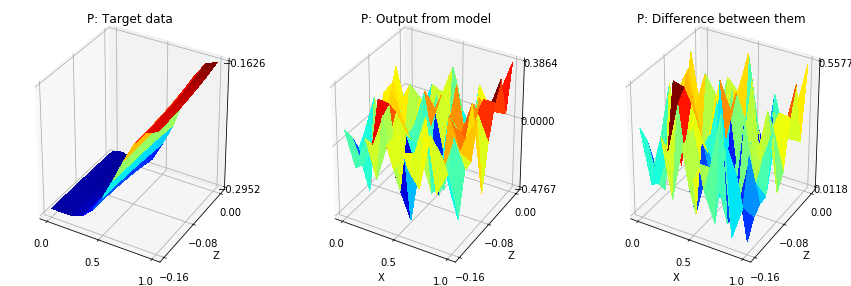

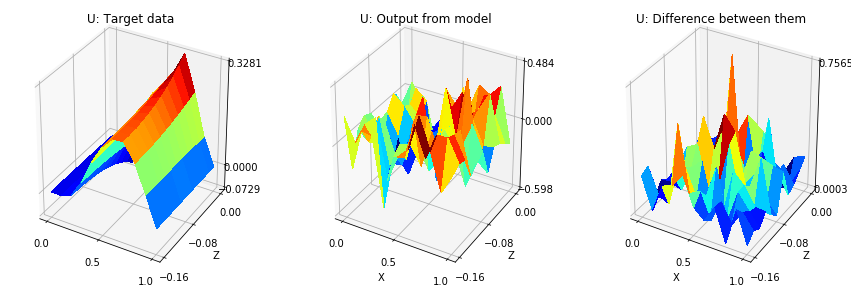

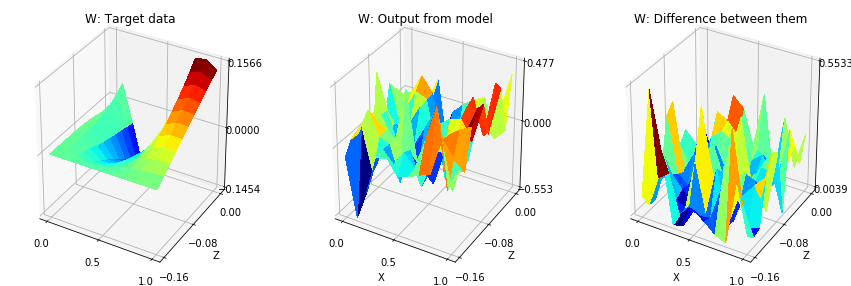

In [62]:
# Test network
test_loss, test_norm = [], []
outputs_from_test, error = [], []
FFNN_PUW.eval()
for it in range(X_uns.shape[0]):
  output_test = FFNN_PUW(Variable(torch.from_numpy(X_uns[it,:].reshape((1,Nx)))))
  outputs_from_test.append(output_test.detach().numpy())
  target_test = Variable(torch.from_numpy(Y_uns[it,:]).reshape((1,3*Nx*Ny)))
  loss_test = MSE_loss_func(output_test,target_test)
  test_loss.append(loss_test.detach().numpy())
  error.append(torch.abs((output_test-target_test)).detach().numpy())
  norm_test = torch.max(torch.abs(output_test-target_test))
  test_norm.append(norm_test.detach().numpy())

idx = np.argmax(test_norm)

# Save to csv-file
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_P_Out_CNNPUW.csv", outputs_from_test[idx][0][P_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_U_Out_CNNPUW.csv", outputs_from_test[idx][0][U_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_W_Out_CNNPUW.csv", outputs_from_test[idx][0][W_idx], delimiter=",")

print('Interval of inf norms: (%f, %f)' % (np.min(test_norm),np.max(test_norm)))
plt.figure(figsize=(5,5))
plt.boxplot(test_norm)
plt.title('Boxplot of inf norms')
plt.show()

print('For test data #%i we observe the greatest error' % (idx))

# Example of a test input 
fig = plt.figure(figsize=(5,5))
plt.plot(xx,X_uns[idx,:],'r-x')
plt.xlabel('x')
plt.ylabel('Potential')
plt.title('Input data')
plt.show()

### PLOT P #####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[idx,P_idx]), 0, np.max(Y_uns[idx,P_idx])])
ax.set_title('P: Target data')
ax.plot_surface(X, Z, Y_uns[idx,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][P_idx]), 0, np.max(outputs_from_test[idx][0][P_idx])])
ax.set_title('P: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][P_idx]), 0, np.max(error[idx][0][P_idx])])
ax.set_title('P: Difference between them')
ax.plot_surface(X, Z, error[idx][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

### PLOT U #####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[idx,U_idx]), 0, np.max(Y_uns[idx,U_idx])])
ax.set_title('U: Target data')
ax.plot_surface(X, Z, Y_uns[idx,U_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][U_idx]), 0, np.max(outputs_from_test[idx][0][U_idx])])
ax.set_title('U: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][U_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][U_idx]), 0, np.max(error[idx][0][U_idx])])
ax.set_title('U: Difference between them')
ax.plot_surface(X, Z, error[idx][0][U_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

#### PLOT W ####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[idx,W_idx]), 0, np.max(Y_uns[idx,W_idx])])
ax.set_title('W: Target data')
ax.plot_surface(X, Z, Y_uns[idx,W_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)


# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][W_idx]), 0, np.max(outputs_from_test[idx][0][W_idx])])
ax.set_title('W: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][W_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][W_idx]), 0, np.max(error[idx][0][W_idx])])
ax.set_title('W: Difference between them')
ax.plot_surface(X, Z, error[idx][0][W_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()
